## AAUtoSig Markdown
This document is a runthrough of our autoencoder model.
Firstly we initialise our installed packages

In [5]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.spatial as sp
import random

from functions import simulate_counts, plotsigs, cosine_HA
from AAUtoSig_init import AAUtoSig, train_AAUtoSig

## Initialise the autoencoder
The following block creates a class to initialize a one-hidden-layer linear autoencoder, and a method for traning the one such model.

## Application
Now we can use our autoencoder on some simulated data

EARLY-STOPPING !
Best epoch found: nº 49
Exiting. . .


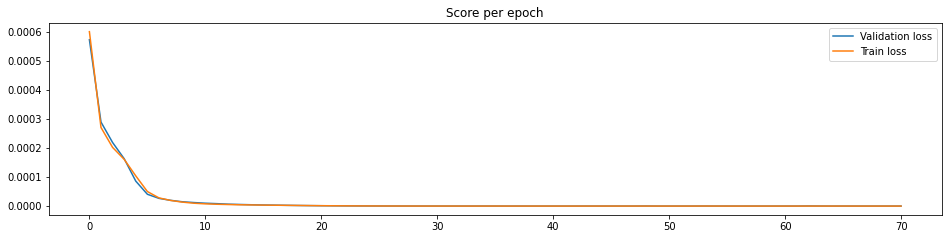

In [6]:
nsigs = 5

#np.random.seed(20)
#random.seed(20)
mf_df, true_sigs,_ = simulate_counts(5,3000, pentanucelotide=False)
tri = mf_df.index
mutation = [t[2:5] for t in tri]

#X = (mf_df / mf_df.sum(axis=0)).T
X = mf_df.T/mf_df.max().max()


#80/20 train/validation split
x_train = X.sample(frac=0.8)
x_val = X.drop(x_train.index)

#choosing the 'true' number of signatures
model = AAUtoSig(dim1 = nsigs)

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss(reduction='mean')

# Using an Adam Optimizer with lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(),
                            lr = 1e-3)
                            
train_AAUtoSig(epochs = 300, 
                model = model, 
                x_train = x_train,
                x_test = x_val, 
                loss_function = loss_function, 
                optimizer = optimizer,
                batch_size=16,
                do_plot = True)

x_test_tensor = torch.tensor(x_val.values, 
                             dtype = torch.float32)

rec_data = model(x_test_tensor)

#the weights of the decoding layer (dec1) is where we find the signatures.
sigs = model.dec1.weight.data    
sigs = pd.DataFrame(sigs.numpy()) 

In [7]:
mat, perm = cosine_HA(sigs.T,true_sigs.T)
sigs = sigs[perm]
sigs.to_numpy().diagonal()
print(np.mean(mat.diagonal()))

0.8290985533234853


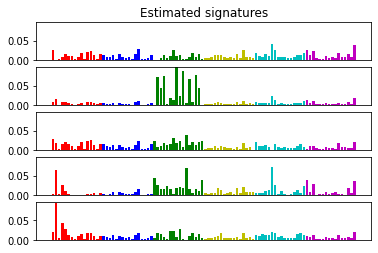

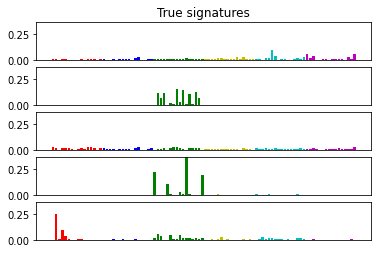

In [8]:
#plot the results
plotsigs(tri, mutation, sigs.to_numpy(), nsigs, "Estimated signatures")  
plotsigs(tri, mutation, true_sigs.to_numpy(), nsigs, "True signatures")  